In [1]:
import os

def import_from_directory(directory, module_name):
    current_dir = os.getcwd()
    os.chdir(directory)
    module = __import__(module_name)
    os.chdir(current_dir)
    return module

model_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'model_base')

2024-05-02 13:50:39.168291: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 13:50:39.206130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 13:50:39.206163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 13:50:39.207244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 13:50:39.213617: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
model_base.set_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/notebooks/'
os.chdir(desired_directory)

tabledataの作成

In [3]:
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Data/tabledata_all.csv')
df_pos = df[df['Adducttype'].str.contains('\]\+') | df['Adducttype'].str.contains('\]2\+')]
df_pos2 = model_base.cal_df_sel_column(df_pos)
df_pos_wide = model_base.cal_wide_df(df_pos2)

In [6]:
columnlist_path = 'Data/model_data/pos/posmodelcolumn_all.pkl'
replacement_dict_path = 'Data/model_data/pos/pos_replacement_dict_all.pkl'
y_test_path = 'Data/model_data/pos/df_pos_ytest.csv'

df_pos_wide2, X_train, X_test, X_eval, y_train, y_test, y_eval, train_d, test_d, y, replacement_dict = \
    model_base.train_test_split_from_df(df_pos_wide, columnlist_path, replacement_dict_path, y_test_path) #split data

y_train_onehot, y_test_onehot, y_eval_onehot = model_base.replace_y_onthot(y, y_train, y_test, y_eval, replacement_dict) #onehot

パラメーターチューニング

In [10]:
model, early_stopping, tensorboard_callback =\
      model_base.prep_patam_tune('pos', X_train, y_train_onehot, X_eval, y_eval_onehot)

# モデルの学習
history = model.fit(X_train, y_train_onehot,                  # トレーニングデータ
                    epochs=500,                        # トレーニングの回数
                    batch_size=30,                     # 勾配更新ごとのサンプル数
                    verbose=1,                         # 進行状況の表示（0：非表示、1,2：表示）
                    validation_data=(X_eval, y_eval_onehot),  # 評価用データ
                    callbacks=[early_stopping,tensorboard_callback]) 

model.save('models/pos_class_model')

In [8]:
from datetime import datetime
from keras.callbacks import EarlyStopping
import keras

In [9]:
early_stopping = EarlyStopping(patience=10, verbose=0) 
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [10]:
model = load_model('models/pos_class_model')

In [11]:
history = model.fit(X_train, y_train_onehot,                  # トレーニングデータ
                    epochs=500,                        # トレーニングの回数
                    batch_size=30,                     # 勾配更新ごとのサンプル数
                    verbose=1,                         # 進行状況の表示（0：非表示、1,2：表示）
                    validation_data=(X_eval, y_eval_onehot),  # 評価用データ
                    callbacks=[early_stopping,tensorboard_callback]) 

Epoch 1/500
181/181 [==============================] - 7s 34ms/step - loss: 0.0377 - acc: 0.9891 - val_loss: 0.3174 - val_acc: 0.9386
Epoch 2/500
181/181 [==============================] - 6s 33ms/step - loss: 0.0187 - acc: 0.9928 - val_loss: 0.3040 - val_acc: 0.9438
Epoch 3/500
181/181 [==============================] - 6s 32ms/step - loss: 0.0171 - acc: 0.9941 - val_loss: 0.3112 - val_acc: 0.9460
Epoch 4/500
181/181 [==============================] - 6s 32ms/step - loss: 0.0144 - acc: 0.9956 - val_loss: 0.3447 - val_acc: 0.9416
Epoch 5/500
181/181 [==============================] - 6s 32ms/step - loss: 0.0119 - acc: 0.9957 - val_loss: 0.3346 - val_acc: 0.9438
Epoch 6/500
181/181 [==============================] - 6s 32ms/step - loss: 0.0153 - acc: 0.9957 - val_loss: 0.3246 - val_acc: 0.9460
Epoch 7/500
181/181 [==============================] - 6s 32ms/step - loss: 0.0111 - acc: 0.9965 - val_loss: 0.3545 - val_acc: 0.9408
Epoch 8/500
181/181 [==============================] - 6s 32ms

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1664)              3457792   
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense_7 (Dense)             (None, 2304)              3836160   
                                                                 
 dropout_1 (Dropout)         (None, 2304)              0         
                                                                 
 dense_8 (Dense)             (None, 3072)              7080960   
                                                                 
 dropout_2 (Dropout)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 63)               

In [13]:
# モデルの定義
model = Sequential()
input_dim = 2114
model.add(Dense(2816, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3968, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2176, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(69, activation='softmax'))

# モデルの描画
plot_model(model, to_file='Data/model_data/pos/pos_model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


SHAP plot

In [14]:
output_path = 'Data/model_data/pos/pos_df_feature.csv'
df_feature = model_base.cal_df_feature(df_pos_wide, output_path)

In [ ]:
pos_class_list = ['TG', 'DG', 'PC', 'CE', 'SM', 'PE', 'EtherDG', 'LPC', 'Cer_NS', 'EtherTG']
X_train_shap, y_train_shap, X_test_shap, y_test_shap =\
    model_base.cal_shap_values(pos_class_list, train_d, test_d)

In [ ]:
explainer = shap.KernelExplainer(model.predict,X_train_shap)
shap_values = explainer.shap_values(X_test_shap)
np.save('Data/model_data/pos/pos_shapvalues.npy', shap_values)

input_path = 'Data/model_data/pos/pos_shapvalues.npy'
save_excle_path = 'Data/model_shap/pos/shap_select10_pos.xlsx'

top_feature_df =\
      model_base.cal_shap_results(input_path, df_feature, pos_class_list, y_test_shap, save_excle_path)

In [ ]:
cl = plt.cm.tab20.colors
cmap_pos = [cl[10], cl[0], cl[18], cl[16], cl[17], cl[4],  cl[6], cl[7], cl[19], cl[8]]
custom_legend_order = ['CE', 'Cer_NS', 'DG','EtherDG', 'EtherTG', 'LPC',  'PC', 'PE', 'TG', 'SM']
save_path = 'Data/model_data/pos/pos_shap.svg'
model_base.plot_shap_results(top_feature_df, cmap_pos, custom_legend_order, save_path, title= 'SHAP summary plot (positive ion mode model)')

モデルの学習曲線

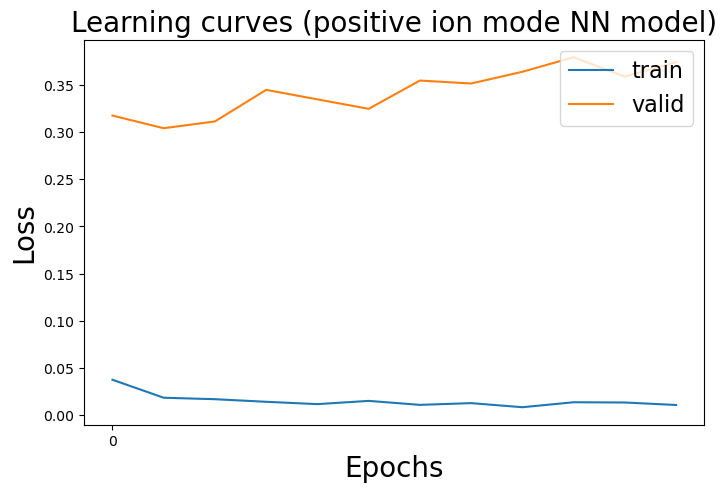

In [15]:
save_path = 'Data/model_data/pos/pos_learning_curve.svg'
model_base.plot_learning_curve(history, save_path, title = 'Learning curves (positive ion mode NN model)')

train, testにおける正答率

In [2]:
model = load_model('models/pos_class_model')

In [17]:
y_pred_train, y_pred_train_max, y_train_acc, y_pred_test, y_pred_test_max, y_test_acc =\
    model_base.modelpred_summary_acc(model, X_train, y_train_onehot, X_test, y_test_onehot)

53/53 [==============================] - 0s 6ms/step
Neural Network_train : 0.9929733727810651
Neural Network_test : 0.9491425192193969


予測結果のまとめ

In [18]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_train_x = pd.concat([pd.DataFrame(y_train).reset_index(drop=True),pd.DataFrame(y_pred_train).rename(columns=replacement_dict_reversed)], axis=1).groupby('Ontology').mean()
df_train_x = df_train_x.reindex(sorted(df_train_x.columns), axis=1)

In [19]:
print('train result')
train_save_path = 'Data/model_data/pos/pos_df_train_predclass.csv'
train_pred1st_num, train_candidate_num, train_all_num, train_df_predclass =\
    model_base.modelpred_summary_detail(df_pos_wide2, replacement_dict_reversed, y_train, y_pred_train, y_pred_train_max, y_train_acc, train_save_path)
print('test result')
test_save_path = 'Data/model_data/pos/pos_df_test_predclass.csv'
test_pred1st_num, test_candidate_num, test_all_num, test_df_predclass =\
    model_base.modelpred_summary_detail(df_pos_wide2, replacement_dict_reversed, y_test, y_pred_test, y_pred_test_max, y_test_acc, test_save_path)

df_model_result = pd.DataFrame(data=[train_pred1st_num,train_candidate_num, train_all_num, test_pred1st_num, test_candidate_num, test_all_num], \
                               index=['train_1st', 'train_candidate', 'train_number','test_1st', 'test_candidate','test_number'])
df_model_result.to_csv('Data/model_data/pos/df_pos_model_pred_result.csv')

train result
1st pred : 0.9929733727810651
candidate : 0.9990754437869822
1st pred num: 5370
candidate num: 5403
all num: 5408
test result
1st pred : 0.9491425192193969
candidate : 0.9822590183323477
1st pred num: 1605
candidate num: 1661
all num: 1691


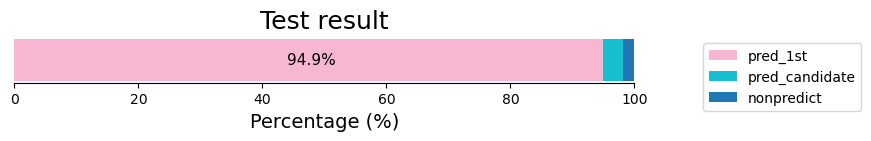

In [20]:
save_path = 'Data/model_data/pos/pos_testresult_percentage.svg'
model_base.plot_bar_plot(test_pred1st_num, test_candidate_num, test_all_num, save_path)

canopusとの比較用データの準備

In [21]:
ont_df_path = 'Data/model_data/pos/subclass_ont_select_pos.csv'
save_path = 'Data/model_data/pos/df_pos_subclass_pred.csv'
subclasslist = ['Monoradylglycerols', 'Ceramides', 'Diradylglycerols',
 'Glycerophosphocholines', 'Triradylglycerols', 'Phosphosphingolipids',
 'Glycosphingolipids', 'Glycerophosphoethanolamines', 'Glycerophosphoglycerols']
model_base.conv_subclass(test_df_predclass, y_test, ont_df_path, save_path, subclasslist)
